In [85]:
import os #for working with files
import zipfile #for unziping
import numpy as np
import pandas as pd
import shutil 
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [112]:
def unzip_data(zip_file, destination_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('After extraction files are in: ', destination_dir)
    
def train_valid_files():
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
            
    for class_name in class_names:
        source_dir = os.path.join(data_root, 'train', class_name)
        for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
            if i % 6 != 0:
                dest_dir = os.path.join(train_dir, class_name) 
            else:
                dest_dir = os.path.join(valid_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
            
def make_test_data():
    src_dir = os.path.join(data_root, 'test')
    dst_dir = os.path.join(test_dir, 'unknown')
    shutil.copytree(src_dir, dst_dir)
    files = os.listdir(dst_dir)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print(f'{len(files)} pictures copied to \'{dst_dir}\'\n')
    
    
def train_model(model, loss, optimizer, scheduler, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_hist = {'train':[], 'valid':[]}
    accuracy_hist = {'train':[], 'valid':[]}
    
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                # Running_acc += (preds_class == labels.data).float().mean()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()                


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))

            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

In [87]:
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

class_names = ['cleaned', 'dirty']

data_root = '/kaggle/working/plates/'

unzip_data('../input/plates.zip', '/kaggle/working/')

After extraction files are in:  /kaggle/working/


In [88]:
train_valid_files()
make_test_data()

100%|██████████| 21/21 [00:00<00:00, 4136.98it/s]

744 pictures copied to 'test/unknown'



In [89]:
os.listdir('/kaggle/working/')

['submission.csv',
 'valid',
 'plates',
 '__MACOSX',
 'train',
 'test',
 '__notebook_source__.ipynb']

In [109]:
train_transforms_1 = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transforms_2 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(hue=0.4, brightness=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transforms_3 = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset_1 = torchvision.datasets.ImageFolder(train_dir, train_transforms_1)
train_dataset_2 = torchvision.datasets.ImageFolder(train_dir, train_transforms_2)
train_dataset_3 = torchvision.datasets.ImageFolder(train_dir, train_transforms_3)

train_dataset = torch.utils.data.ConcatDataset([train_dir,train_dataset_1, train_dataset_2, train_dataset_3])

val_dataset = torchvision.datasets.ImageFolder(valid_dir, val_transforms)

batch_size = 6
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)

batch_size = 6
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

# Mini report of loaded data
print('Train, Valid and Test datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(val_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))

Train, Valid and Test datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          18       107
Valid           2         6
Test          124       744


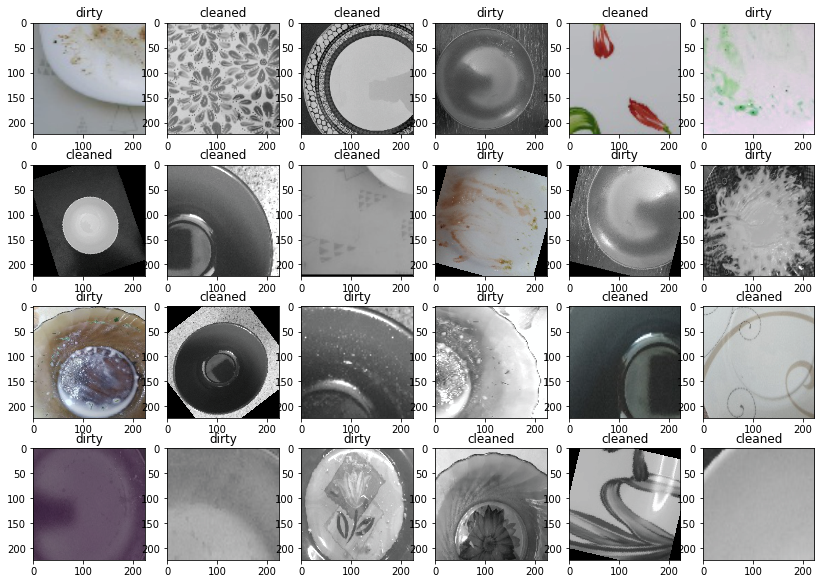

In [100]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(4):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        plt.subplot(4, 6, i*batch_size + j+1)
        plt.title(class_names[y_batch[j].item()])
        plt.imshow(X_batch[j].permute(1, 2, 0).numpy() * std + mean)

In [101]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [102]:
model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=50);

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 50|    0.7147    0.4804|    0.8650    0.5000|
  2/ 50|    0.6528    0.6961|    0.5354    0.6250|
  3/ 50|    0.5259    0.7647|    0.7338    0.7500|
  4/ 50|    0.4680    0.7549|    1.3798    0.3750|
  5/ 50|    0.7841    0.6176|    1.4889    0.5000|
  6/ 50|    0.7891    0.6176|    1.5701    0.5000|
  7/ 50|    0.6309    0.7059|    0.8983    0.5000|
  8/ 50|    0.3762    0.8137|    0.7929    0.6250|
  9/ 50|    0.3346    0.8824|    0.4086    0.7500|
 10/ 50|    0.4695    0.8039|    0.8507    0.5000|
 11/ 50|    0.4452    0.7941|    0.6221    0.5000|
 12/ 50|    0.3824    0.8431|    0.5633    0.7500|
 13/ 50|    0.4454    0.7843|    0.6301    0.5000|
 14/ 50|    0.3233    0.8431|    0.8965    0.7500|
 15/ 50|    0.4151    0.8235|    0.6454    0.8750|
 16/ 50|    0.4035    0.7745|    0.5135    0.8750|
 17/ 50|    0.3540    0.8431|  

dict_keys(['train', 'valid'])


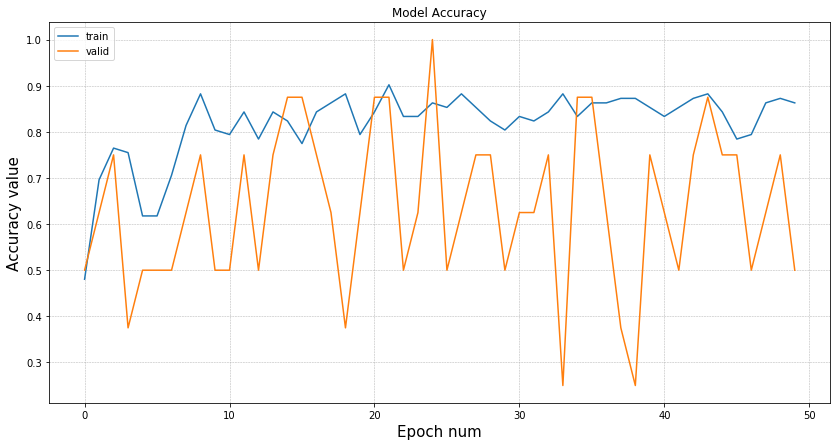

In [108]:
# Model accuracies visualization

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [ ]:
# Model loss-function visualization
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

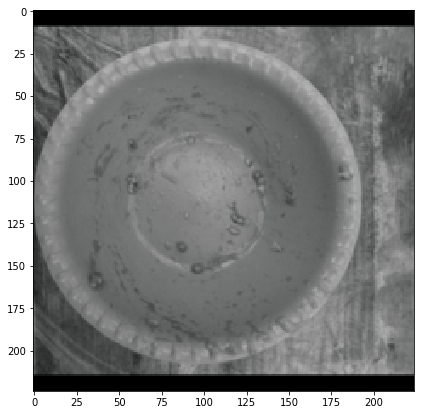

In [ ]:
def show_input(input_tensor):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.show()
    plt.pause(0.001)
    

inputs, labels, paths = next(iter(test_dataloader))

for img in inputs:
    show_input(img)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train valid test